In [1]:
import openalexnet as oanet
import pandas as pd
import igraph as ig
import numpy as np
import matplotlib as mpl
import json

import nltk
nltk.download('wordnet')

from tqdm.auto import tqdm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /home/marlon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
filterData = {
    "is_paratext": "false",  # Only works, no paratexts (https://en.wikipedia.org/wiki/Paratext)
    "type": "journal-article", # Only journal articles
    "from_publication_date": "2020-01-01" # Published after 2020
}

searchString = "\"complex network\"" # works containing the string "complex networks"

sortData = [
    "cited_by_count:desc" # sort by number of citations in descending order
]

entityType = "works"

openalex = oanet.OpenAlexAPI()

entities = openalex.getEntities(entityType,
                                filter=filterData,
                                search=searchString,
                                sort=sortData,
                                maxEntities=1000)

/tmp/ipykernel_255223/1450576337.py:17: UserWarning: Number of entities (2286) in OpenAlex is larger than the maximum allowed (1000). Only the first 1000 entities will be returned. You can set the maximum number of entities to be returned by setting maxEntities=yourNumber. To ignore this warning, set ignoreEntitiesLimitWarning=True.
  entities = openalex.getEntities(entityType,


In [3]:
# df = pd.DataFrame(entities)
# df = df[df['abstract_inverted_index'].notna()]

In [4]:
k_DefaultKeptItems = [
    "id",
    "doi",
    "title",
    "display_name",
    "publication_year",
    "publication_date",
    "type",
    "authorships",
    "concepts",
    "host_venue",
    'abstract_inverted_index' 
]

network = oanet.createNetworks(entities,
                               networkTypes=["citation"],
                               simplifyNetworks=True,
                               keptAttributes = k_DefaultKeptItems,
                               showProgress=True)

Extracting edges and attributes:   0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
network = network['citation']
network.summary()

'IGRAPH D--T 1000 647 -- \n+ attr: abstract_inverted_index (v), authorships (v), concepts (v), display_name (v), doi (v), host_venue (v), id (v), publication_date (v), publication_year (v), title (v), type (v)'

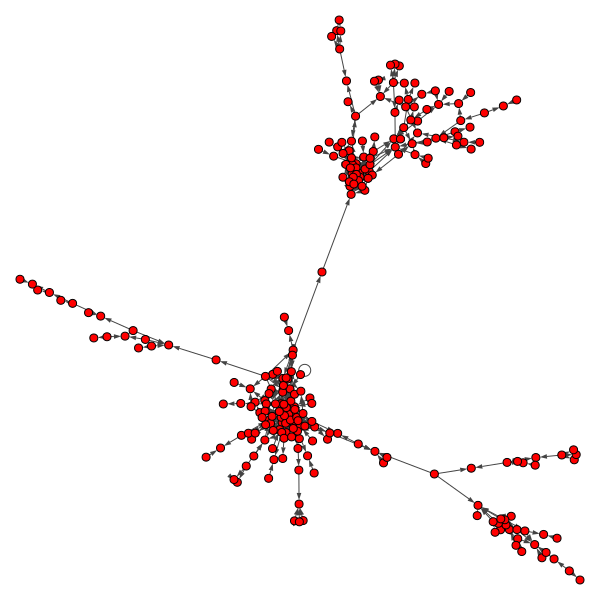

In [6]:
connected_components = network.components("weak").giant()
ig.plot(
    connected_components,
    vertex_size = 8.0,
    edge_arrow_size = 0.5
)

In [7]:
connected_components.summary()

'IGRAPH D--T 247 479 -- \n+ attr: abstract_inverted_index (v), authorships (v), concepts (v), display_name (v), doi (v), host_venue (v), id (v), publication_date (v), publication_year (v), title (v), type (v)'

In [8]:
connected_components.vs['community'] = connected_components.as_undirected().community_multilevel().membership

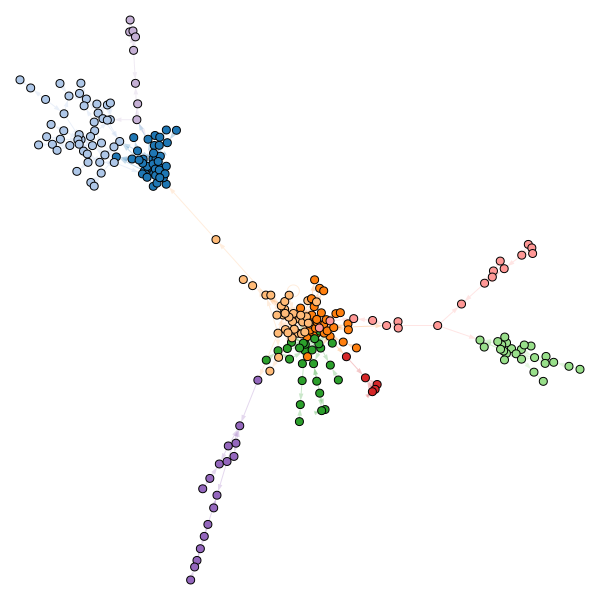

In [9]:
vertex_colors = [mpl.cm.tab20(index) for index in connected_components.vs["community"]]
edge_colors = [vertex_colors[edge.source][:-1]+(0.25,) for edge in connected_components.es]

# labels = connected_components.vs["display_name"]

layout = connected_components.layout("fr")
ig.plot(connected_components,
        layout = layout,
#         vertex_label = labels,
#         vertex_label_size = 5,
        vertex_size = 8,
        vertex_color = vertex_colors,
        edge_arrow_size = 0.5,
        edge_color = edge_colors
        )

In [10]:
communities = np.unique(np.array(connected_components.vs['community']))

def init_communities(communities):
    c = {}
    for community in communities:
        c[community] = 0
    return c

In [11]:
n_vertex = connected_components.vcount()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

for i in tqdm(range(n_vertex)):
    if (connected_components.vs[i]['abstract_inverted_index'] == 'null'):
        continue
    abstract = list(json.loads(connected_components.vs[i]['abstract_inverted_index']))
    abstract = [w for w in abstract if not w.lower() in stop_words]
    connected_components.vs[i]['abstract_inverted_index'] = {lemmatizer.lemmatize(w) for w in abstract}

  0%|          | 0/247 [00:00<?, ?it/s]

In [12]:
metadata_word = {}
words = set()

for i in tqdm(range(n_vertex)):
    for word in connected_components.vs[i]['abstract_inverted_index']:
        if word in words: 
            continue
        metadata_word[word] = init_communities(communities)
        metadata_word[word][connected_components.vs[i]['community']] += 1
        for j in range(i+1, n_vertex):
            if word in connected_components.vs[j]['abstract_inverted_index']:
                metadata_word[word][connected_components.vs[j]['community']] += 1
        words.add(word)

  0%|          | 0/247 [00:00<?, ?it/s]

In [13]:
def sum_out_community(metadata_word, community):
    sum = 0
    for c in metadata_word.keys():
        if c != community:
            sum += metadata_word[c]
    return sum

In [14]:
def alpha_communities(connected_components, communities):
    alpha_module = {}
    for c in communities:
        alpha_module[c] = connected_components.vs['community'].count(c)
    return alpha_module

In [15]:
"""
    N     = total number of papers in the network
    F_in  = relative in-community frequency
    F_out = relative out-community frequency
    I     = importance of keywords
"""

N = n_vertex
I = {}
alpha_module = alpha_communities(connected_components, communities)

for community in tqdm(communities):
    I[community] = {}
    for word in metadata_word:
        F_in = metadata_word[word][community] / alpha_module[community]
        F_out = sum_out_community(metadata_word[word], community) / (N - alpha_module[community])
        I[community][word] = F_in - F_out
    I[community] = dict(sorted(I[community].items(), key=lambda item: item[1], reverse=True))

  0%|          | 0/10 [00:00<?, ?it/s]

In [16]:
I

{0: {'error': 0.6858974358974359,
  'estimation': 0.5913461538461539,
  'state': 0.5897435897435896,
  'estimator': 0.5496794871794872,
  'design': 0.532051282051282,
  'class': 0.5128205128205128,
  'problem': 0.45512820512820507,
  'stochastic': 0.4407051282051282,
  'desired': 0.4310897435897436,
  'gain': 0.4278846153846154,
  'example': 0.423076923076923,
  'condition': 0.423076923076923,
  'matrix': 0.39262820512820507,
  'measurement': 0.391025641025641,
  'transmission': 0.3766025641025641,
  'sufficient': 0.3701923076923077,
  'simulation': 0.360576923076923,
  'provided': 0.3573717948717949,
  'bound': 0.34134615384615385,
  'Finally,': 0.3173076923076923,
  'addressed': 0.3141025641025641,
  'certain': 0.2948717948717948,
  'event-triggered': 0.2948717948717948,
  'dynamic': 0.28685897435897434,
  'communication': 0.28685897435897434,
  'upper': 0.27403846153846156,
  'recursive': 0.2676282051282051,
  'sensor': 0.2676282051282051,
  'ensure': 0.2580128205128205,
  'subject'